In [15]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import colors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pathlib import Path
import numpy as np

from utils import cluster
from utils import plot_utils
from utils.config import TrackerConfig

In [16]:
config = TrackerConfig()
#config = TrackerConfig().from_yaml("config_mod.yaml")

var_name = config.dataset.label_filtered_var
labeled_nc_folder = config.paths.labeled_nc_folder
csv_folder = config.paths.csv_folder
cao_cluster_table = config.files.cao_cluster_table
cao_chain_table = config.files.cao_chain_table
distance_threshold_km = 1000

In [43]:
cao_chains = pd.read_csv("results/csv/cao_chains.csv")

,chain_id,start_date,end_date,duration_days,max_area_km2,mean_area_km2,total_area_km2,min_temperature,mean_min_temperature,mean_temperature,max_lat,min_lat,max_lon,min_lon,total_clusters,max_clusters_per_day,mean_clusters_per_day,max_cluster_area_day,coldest_temp_day
0,1,1940-01-01,1940-01-03,3,1.512925e+06,1.298516e+06,3.895547e+06,-3.402979,-3.186912,-2.132491,127,126,244,231,3,1,1.0,1940-01-02,1940-01-02
1,2,1940-01-05,1940-01-08,4,1.905842e+06,1.366428e+06,5.465711e+06,-3.829473,-3.585055,-2.147176,128,123,242,193,4,1,1.0,1940-01-06,1940-01-06
2,3,1940-01-13,1940-01-29,17,6.760252e+06,4.245533e+06,7.217406e+07,-4.716448,-4.028594,-2.149969,146,87,271,134,17,1,1.0,1940-01-19,1940-01-15
3,4,1940-01-31,1940-01-31,1,5.175335e+05,5.175335e+05,5.175335e+05,-2.934499,-2.934499,-1.946476,148,148,251,251,1,1,1.0,1940-01-31,1940-01-31
4,5,1940-02-03,1940-02-03,1,2.172458e+06,2.172458e+06,2.172458e+06,-3.898732,-3.898732,-2.047252,134,134,281,281,1,1,1.0,1940-02-03,1940-02-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
919,920,2022-03-12,2022-03-13,2,5.977498e+05,5.928777e+05,1.185755e+06,-2.586852,-2.315305,-1.706135,164,155,286,211,2,1,1.0,2022-03-13,2022-03-12
920,921,2022-03-15,2022-03-16,2,1.069828e+06,8.206052e+05,1.641210e+06,-2.589100,-2.388486,-1.824417,50,39,402,391,2,1,1.0,2022-03-16,2022-03-16
921,922,2022-12-01,2022-12-02,2,9.467208e+05,8.510055e+05,1.702011e+06,-3.636251,-3.475945,-2.031680,74,64,125,104,2,1,1.0,2022-12-01,2022-12-02
922,923,2022-12-06,2022-12-07,2,7.245246e+05,6.236752e+05,1.247350e+06,-2.759012,-2.729882,-1.857304,74,59,181,143,2,1,1.0,2022-12-07,2022-12-07


In [2]:
clusters_with_chains = pd.read_csv('results/csv/clusters_with_chains.csv')
clusters_with_chains.time = pd.to_datetime(clusters_with_chains.time)

In [40]:
clusters_with_chains

,label,area,time,cm_lat,cm_lon,mean,stdev,median,min_value,min_lat,min_lon,chain_id
0,14,1.173948e+06,1940-01-01,126,234,-2.026448,0.312324,-2.034531,-2.933522,131,223,1
1,4,1.512925e+06,1940-01-02,127,231,-2.210192,0.451129,-2.170007,-3.402979,131,223,1
2,8,1.208674e+06,1940-01-03,126,244,-2.160834,0.369552,-2.169869,-3.224235,127,285,1
3,15,1.400601e+06,1940-01-05,123,223,-2.121999,0.465984,-2.021502,-3.299717,115,207,2
4,19,1.905842e+06,1940-01-06,128,242,-2.012462,0.491646,-1.827198,-3.829473,131,267,2
...,...,...,...,...,...,...,...,...,...,...,...,...
5560,5,7.982326e+06,2022-12-23,105,178,-2.286555,0.484432,-2.270290,-4.119081,121,182,924
5561,13,5.429547e+05,2022-12-24,26,49,-1.869146,0.219762,-1.840232,-2.734346,31,6,924
5562,52,5.751150e+06,2022-12-24,143,235,-2.214592,0.408476,-2.185147,-3.706085,190,209,924
5563,20,3.954127e+06,2022-12-25,151,236,-1.941915,0.330148,-1.859088,-3.504250,194,210,924


In [3]:
img_path = 'results/img/latest'
labeled_nc_folder = 'results/nc/labeled_nc'

In [4]:
cao = xr.open_mfdataset(f"{labeled_nc_folder}/*.nc")

In [38]:
chain_list = [879,848,837,840]

In [54]:
id=2
ndays = cao_chains.loc[cao_chains.chain_id==id,"duration_days"].values[0]
ndays > 5

np.False_

In [ ]:
for id in cao_chains.chain_id:
    print(id)
    ndays = cao_chains.loc[cao_chains.chain_id==id,"duration_days"].values[0]
    if(ndays < 3):
        continue  
    chain = clusters_with_chains[clusters_with_chains.chain_id == id]
    start_date = chain.time.min()
    end_date = chain.time.max() #+ pd.Timedelta('1 day')
    delta = (end_date - start_date).days
    path = f'{img_path}/{delta:02d}_{start_date.strftime('%Y%m%d')}_{end_date.strftime('%Y%m%d')}_{id:04d}'
    Path(path).mkdir(parents=True, exist_ok=True)
    days = np.unique(chain.time)
    for d in pd.date_range(start_date,end_date):
        cao_chunk = cao.sel(time =d)
        plt.figure(figsize=(6, 4))
        axes = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-100))
        plot_utils.da_plot_zero_centered(cao_chunk['scaled_anomaly'],with_colorbar=False)
        labels = np.unique(chain.label)
        for label_cluster in labels:
            cao_chunk['labeled_clusters_filtered'].where(cao_chunk['labeled_clusters_filtered']==label_cluster,other=0).plot.contour(transform=ccrs.PlateCarree(),colors='yellow',linewidths=0.3)
        axes.coastlines()
        axes.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
        axes.set_extent((-140, -50, 20, 90),ccrs.PlateCarree())
        plt.savefig(f'{path}/{d.strftime('%Y%m%d')}')
        plt.close()
    
    #print("----")
    #print()

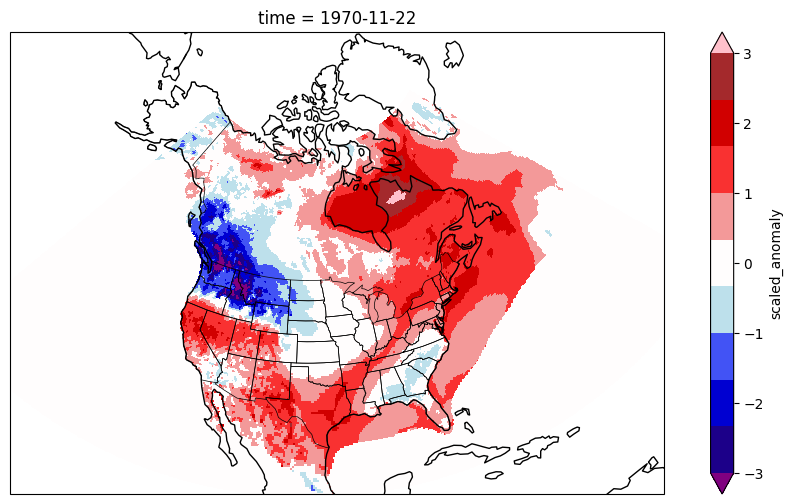

In [26]:
cao_chunk = cao.sel(time = '1970-11-22')
plt.figure(figsize=(12, 6))
axes = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-100))
plot_utils.da_plot_zero_centered(cao_chunk['scaled_anomaly'])
cao_chunk['labeled_clusters_filtered'].where(cao_chunk['labeled_clusters_filtered']==7,other=0).plot.contour(transform=ccrs.PlateCarree(),colors='yellow',linewidths=0.3)
axes.coastlines()
axes.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
axes.set_extent((-140, -50, 20, 90),ccrs.PlateCarree())

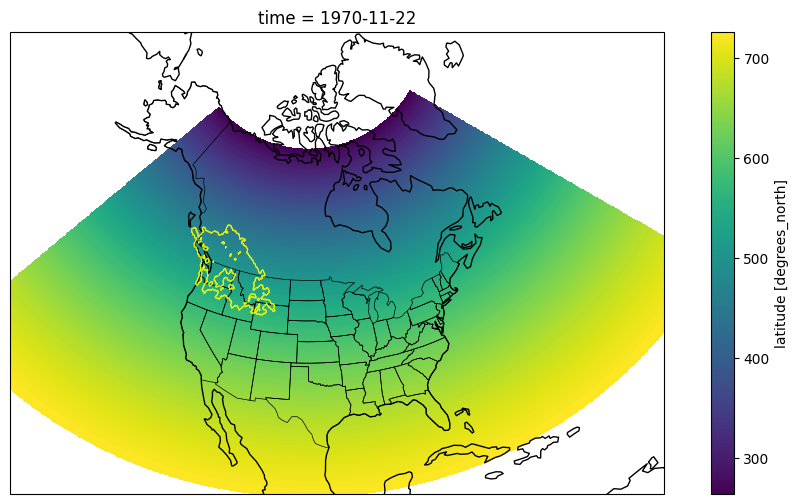

In [31]:
plt.figure(figsize=(12, 6))
axes = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-100))
cao_chunk['areas'].plot(transform=ccrs.PlateCarree())
cao_chunk['labeled_clusters_filtered'].where(cao_chunk['labeled_clusters_filtered']==4,other=0).plot.contour(transform=ccrs.PlateCarree(),colors='yellow',linewidths=0.3)
axes.coastlines()
axes.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
axes.set_extent((-140, -50, 20, 90),ccrs.PlateCarree())

In [22]:
from scipy import ndimage

In [27]:
np.unique(cao_chunk['labeled_clusters_filtered'])

array([0, 4])

In [29]:
ndimage.sum_labels(cao_chunk['areas'],cao_chunk['labeled_clusters_filtered'],4)

np.float64(985559.6864784546)

In [3]:
chains = pd.read_csv('results/csv/cao_chains.csv')
chains.date = pd.to_datetime(chains.date)

In [4]:
chains.groupby('chain_id').count().sort_values('date',ascending=False).head(20)

,from_label,to_label,date
chain_id,,,
54,17,17,17
51,16,16,16
62,14,14,14
23,10,10,10
10,9,9,9
41,7,7,7
18,7,7,7
43,7,7,7
37,7,7,7


In [5]:
#chains == -1 means a single chain (2 days)
#max_chain = chains.chain_id.max()
#N = len(chains.loc[chains['chain_id'] == -1, 'chain_id'])
#chains.loc[chains['chain_id'] == -1, 'chain_id'] = max_chain + range(1,(N+1))
#N/len(np.unique(chains.chain_id))

In [5]:
cao = xr.open_mfdataset(f"{labeled_nc_folder}/*.nc")

In [6]:
clusters = pd.read_csv('results/csv/cao_clusters.csv')
clusters.time = pd.to_datetime(clusters.time)

In [7]:
#clusters = clusters[clusters.area>500000]
#clusters[clusters.time.dt.year==2003].sort_values('min_value',ascending=True).head(5)
clusters.sort_values('mean',ascending=True).head(20)

,label,area,time,cm_lat,cm_lon,mean,stdev,median,min_value,min_lat,min_lon
125,7,6.120170e+06,1985-01-21,142,259,-2.864021,0.808389,-2.906841,-5.217710,135,265
193,13,7.600911e+06,1989-12-23,137,241,-2.725777,0.821145,-2.598447,-5.259268,190,209
194,14,5.083481e+06,1989-12-24,146,251,-2.596156,0.721411,-2.571477,-5.107413,176,281
192,11,8.376034e+06,1989-12-22,124,231,-2.575363,0.755642,-2.424891,-5.218019,115,191
124,8,6.812067e+06,1985-01-20,123,232,-2.456660,0.655821,-2.346627,-4.273319,132,234
34,9,8.500942e+06,1982-01-11,127,254,-2.412424,0.560917,-2.418117,-3.863591,142,264
306,24,8.668922e+06,1996-02-03,111,211,-2.412007,0.596549,-2.346778,-4.975113,95,120
265,30,5.759571e+06,1994-01-16,114,287,-2.407073,0.525200,-2.438499,-4.234108,124,276
269,20,7.736992e+06,1994-01-19,114,272,-2.358535,0.699904,-2.177940,-4.764121,134,269
67,11,5.177987e+05,1983-01-14,32,380,-2.358236,0.598892,-2.258903,-3.722906,34,393


In [23]:
new_coords = plot_utils.convert_cmass(cm_lat=clusters["cm_lat"],cm_lon=clusters["cm_lon"],latitude=cao.latitude.values,longitude=cao.longitude.values)
new_lons = list()
new_lats = list()
for c in new_coords:
    new_lons.append(c[0])
    new_lats.append(c[1])

clusters["cm_lat_prj"] = new_lats
clusters["cm_lon_prj"] = new_lons

In [8]:
chains

,from_label,to_label,date,chain_id
0,7,7,1985-01-01,1
1,48,46,1985-01-02,2
2,46,60,1985-01-03,2
3,15,43,1985-01-12,3
4,30,24,1985-01-12,4
...,...,...,...,...
105,16,4,1996-12-28,29
106,4,1,1996-12-29,29
107,4,27,1996-12-29,29
108,1,8,1996-12-30,29


In [10]:
strong_caos_northeast = pd.read_csv(r"data\time_of_strongest_cao.csv")
strong_caos_northeast.head(5)
strong_caos_northeast.time = pd.to_datetime(strong_caos_northeast.time)

In [13]:

df = strong_caos_northeast.merge(
    chains,
    left_on=['time'],
    right_on=['date'],
    suffixes=('_from', '_to')
)

In [14]:
df.sort_values('time')

,time,tanom_cao,cao_area_weighted,t2min_weighted,year,cao_index,month,day,year_date,decade,from_label,to_label,date,chain_id
15,1980-02-29,-1.946499,0.562944,-17.332219,1980.0,1.095769,2,120,1980-01-01,1980,6,4,1980-02-29,2
2,1981-01-04,-2.517184,0.993413,-23.732627,1981.0,2.500604,1,64,1981-01-01,1980,7,9,1981-01-04,5
0,1982-01-17,-2.798209,0.999425,-25.221155,1982.0,2.796601,1,77,1982-01-01,1980,19,1,1982-01-17,10
16,1983-01-19,-1.875053,0.458435,-16.585760,1983.0,0.859589,1,79,1983-01-01,1980,26,15,1983-01-19,16
3,1984-01-21,-2.377135,0.935771,-22.499754,1984.0,2.224453,1,81,1984-01-01,1980,5,5,1984-01-21,23
8,1985-01-21,-2.826842,0.649871,-20.710189,1985.0,1.837083,1,81,1985-01-01,1980,7,12,1985-01-21,27
12,1986-01-15,-2.013481,0.666774,-18.509980,1986.0,1.342537,1,75,1986-01-01,1980,1,2,1986-01-15,31
14,1987-02-15,-2.058744,0.638458,-17.860655,1987.0,1.314422,2,106,1987-01-01,1980,11,4,1987-02-15,36
7,1988-01-14,-2.234891,0.834944,-20.880704,1988.0,1.866008,1,74,1988-01-01,1980,4,9,1988-01-14,38
9,1989-12-22,-2.306208,0.737285,-19.721443,1990.0,1.700333,12,51,1989-01-01,1990,11,13,1989-12-22,43


In [23]:
unique_chains = np.unique(df.chain_id)

In [9]:
chains

,from_label,to_label,date,chain_id
0,16,10,1980-02-22,1
1,6,4,1980-02-29,2
2,4,8,1980-03-01,2
3,8,24,1980-03-02,2
4,24,16,1980-03-03,2
...,...,...,...,...
265,30,56,2000-01-18,78
266,7,6,2000-01-21,79
267,20,4,2000-01-26,80
268,4,7,2000-01-27,80


In [ ]:
for id in chains['chain_id'].unique():
#for id in unique_chains:
#for id in [2000]:
    if(id==-1):
        continue  
    #print(id)
    chain = chains[chains.chain_id==id]
    start_date = chain.date.min()
    end_date = chain.date.max() + pd.Timedelta('1 day')
    delta = (end_date - start_date).days
    path = f'{img_path}/{delta:02d}_{start_date.strftime('%Y%m%d')}_{end_date.strftime('%Y%m%d')}_{id:04d}'
    Path(path).mkdir(parents=True, exist_ok=True)
    print(start_date)
    print(end_date)
    last_chain = chain[-1:]
    last_chain_pd = pd.DataFrame({"from_label": last_chain.to_label,"to_label": 0, "date": last_chain.date+ pd.Timedelta('1 day'), "chain_id": last_chain.chain_id })
    chain = pd.concat([chain, last_chain_pd], ignore_index=True)


    #Path(path).mkdir(parents=True, exist_ok=True)
    for index, row in chain.iterrows():
        #print(row['date'])
        cao_chunk = cao.sel(time = row['date'])
        plt.figure(figsize=(12, 6))
        axes = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-100))
        #axes = plt.axes(projection=ccrs.PlateCarree())
        plot_utils.da_plot_zero_centered(cao_chunk['scaled_anomaly'])
        cao_chunk['labeled_clusters_filtered'].where(cao_chunk['labeled_clusters_filtered']==row['from_label'],other=0).plot.contour(transform=ccrs.PlateCarree(),colors='yellow',linewidths=0.3)
        axes.coastlines()
        axes.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
        axes.set_extent((-140, -50, 20, 90),ccrs.PlateCarree())

        #center of mass
        #lon = clusters.loc[(clusters.time==row['date']) & (clusters.label==row['from_label']),'cm_lon_prj']
        #lat = clusters.loc[(clusters.time==row['date']) & (clusters.label==row['from_label']),'cm_lat_prj']
        #plt.scatter(lon,lat,marker='x',color='yellow')

        plt.savefig(f'{path}/{row['date'].strftime('%Y%m%d')}')
        plt.close()
    
    print("----")
    print()

In [35]:
#Check labels in days with more than 1 cold region

counts = (clusters.groupby('time')['label'].count()).reset_index()
counts = counts[counts.label > 1]
counts

,time,label
1,1985-01-02,2
4,1985-01-12,3
5,1985-01-13,2
19,1985-02-02,3
20,1985-02-03,2
21,1985-02-04,2
22,1985-02-05,2
23,1985-02-06,2
24,1985-02-07,2
25,1985-02-08,3


In [9]:
from scipy import ndimage
def edge_to_edge_distance_fast(ds, label1, label2):
    region1 = (ds.labeled_clusters_filtered == label1)
    region2 = (ds.labeled_clusters_filtered == label2)
    
    # Distance transform: distance from each pixel to nearest region1 pixel
    distances = ndimage.distance_transform_edt(~region1)
    
    # Find minimum distance at region2 pixels
    min_pixel_distance = distances[region2].min()
    
    # Convert pixel distance to km (depends on your grid resolution)
    # This assumes roughly 1 degree ≈ 111 km
    grid_resolution_km = 111  # adjust based on your actual grid
    return min_pixel_distance * grid_resolution_km

d = '1985-01-02'
cao_chunk = cao.sel(time = '1985-01-02')
region1, region2 = np.unique(cao_chunk['labeled_clusters_filtered'].values)[1:]
edge_to_edge_distance_fast(cao_chunk,region1,region2)

KeyError: "not all values found in index 'time'. Try setting the `method` keyword argument (example: method='nearest')."

In [8]:
cao_chunk = cao.sel(time = '1985-01-02')
plt.figure(figsize=(12, 6))
axes = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-100))
plot_utils.da_plot_zero_centered(cao_chunk['scaled_anomaly'])

cao_chunk['labeled_clusters_filtered'].where(cao_chunk['labeled_clusters_filtered']==15,other=0).plot.contour(transform=ccrs.PlateCarree(),colors='yellow',linewidths=0.3)
cao_chunk['labeled_clusters_filtered'].where(cao_chunk['labeled_clusters_filtered']==38,other=0).plot.contour(transform=ccrs.PlateCarree(),colors='pink',linewidths=0.3)

axes.coastlines()
axes.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
axes.set_extent((-140, -50, 20, 90),ccrs.PlateCarree())

KeyError: "not all values found in index 'time'. Try setting the `method` keyword argument (example: method='nearest')."

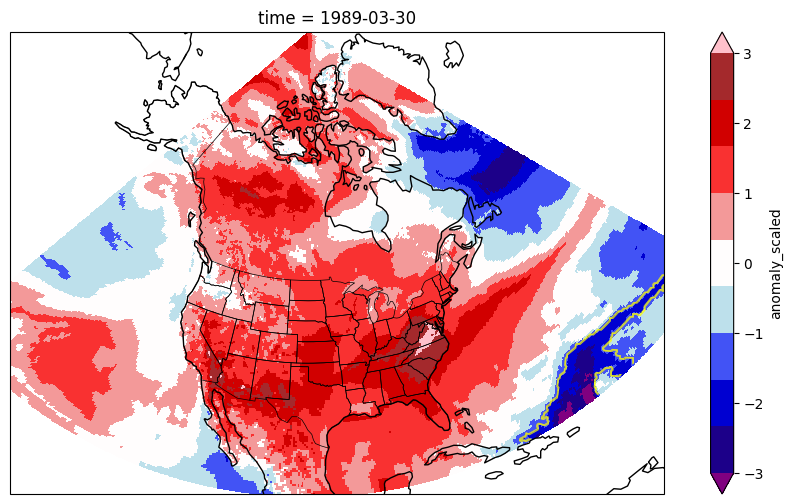

In [ ]:
cao_chunk = cao.sel(time = '1989-03-30')
plt.figure(figsize=(12, 6))
axes = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-100))
plot_utils.da_plot_zero_centered(cao_chunk['anomaly_scaled'])
cao_chunk['labeled_clusters_filtered'].where(cao_chunk['labeled_clusters_filtered']==7,other=0).plot.contour(transform=ccrs.PlateCarree(),colors='yellow',linewidths=0.3)
axes.coastlines()
axes.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
axes.set_extent((-140, -50, 20, 90),ccrs.PlateCarree())

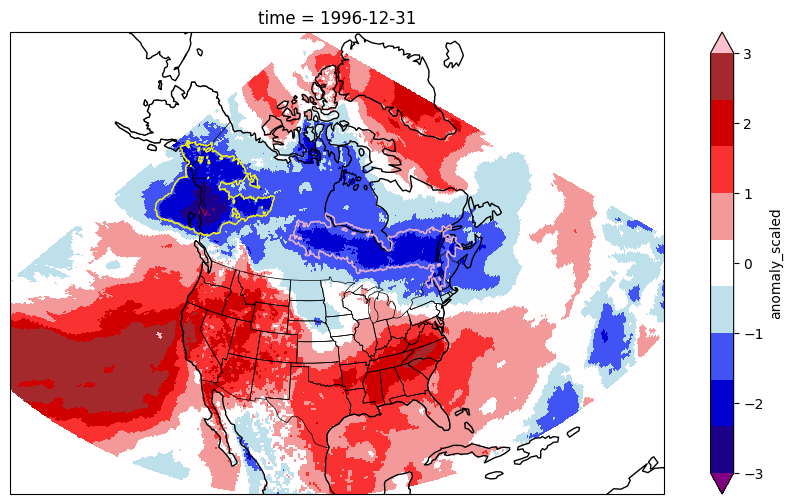

In [47]:
cao_chunk = cao.sel(time = '1996-12-31')
plt.figure(figsize=(12, 6))
axes = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-100))
plot_utils.da_plot_zero_centered(cao_chunk['anomaly_scaled'])

cao_chunk['labeled_clusters_filtered'].where(cao_chunk['labeled_clusters_filtered']==15,other=0).plot.contour(transform=ccrs.PlateCarree(),colors='yellow',linewidths=0.3)
cao_chunk['labeled_clusters_filtered'].where(cao_chunk['labeled_clusters_filtered']==38,other=0).plot.contour(transform=ccrs.PlateCarree(),colors='pink',linewidths=0.3)

axes.coastlines()
axes.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
axes.set_extent((-140, -50, 20, 90),ccrs.PlateCarree())

In [378]:
land_sea_mask = xr.open_dataarray('data/IMERG_land_sea_mask.nc')

In [379]:
land_sea_mask = xr.open_dataarray('data/IMERG_land_sea_mask.nc')

# Convert 0-360 longitude to -180 to 180
land_sea_mask = land_sea_mask.assign_coords(
    lon=(((land_sea_mask.lon + 180) % 360) - 180)
).sortby('lon').rename({'lat': 'latitude', 'lon': 'longitude'})

reference_array = cao.isel(time=0)

# Add padding to reference coordinates
padding_degrees = 5  # adjust as needed

# Get reference bounds and add padding
ref_lat_min = float(reference_array.latitude.min()) - padding_degrees
ref_lat_max = float(reference_array.latitude.max()) + padding_degrees
ref_lon_min = float(reference_array.longitude.min()) - padding_degrees
ref_lon_max = float(reference_array.longitude.max()) + padding_degrees

# Create expanded coordinate arrays
# First, get the original resolution
lat_res = abs(reference_array.latitude[1] - reference_array.latitude[0])
lon_res = abs(reference_array.longitude[1] - reference_array.longitude[0])

# Create new expanded coordinate arrays
expanded_lats = np.arange(ref_lat_min, ref_lat_max + lat_res, lat_res)
expanded_lons = np.arange(ref_lon_min, ref_lon_max + lon_res, lon_res)

land_sea_mask = land_sea_mask.interp(
    latitude=reference_array['labeled_clusters_filtered'].latitude,
    longitude=reference_array['labeled_clusters_filtered'].longitude,
    method='nearest'  # or 'nearest', 'cubic'
)

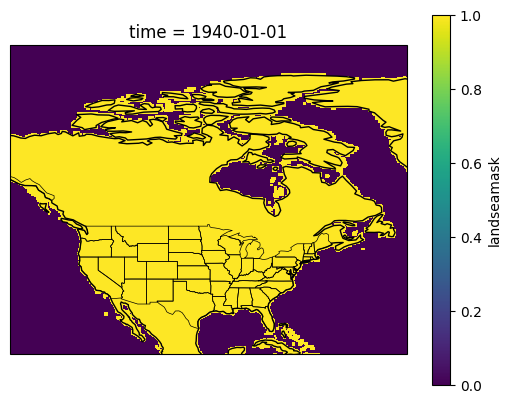

In [383]:
mask=land_sea_mask<100
axes = plt.axes(projection=ccrs.PlateCarree())
mask.plot()
axes.coastlines()
axes.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
#plt.figure(figsize=(12, 6))
#plot_utils.da_plot_zero_centered(cao_chunk['anomaly_scaled'])
#cao_chunk['labeled_clusters_filtered'].where(cao_chunk['labeled_clusters_filtered']==15,other=0).plot.contour(transform=ccrs.PlateCarree(),colors='yellow',linewidths=0.3)
#axes.coastlines()
#axes.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
axes.set_extent((-140, -50, 20, 90),ccrs.PlateCarree())

In [227]:
cao_chunk = cao.sel(time='1943-03-30')
#cao_chunk = cao.sel(time = '1943-03-30')


In [229]:
day_data =  cao_chunk
day_data['labeled_clusters_filtered'] = day_data['labeled_clusters_filtered'].where(mask,0)
day_data=day_data.assign_coords(time=cao_chunk.time)

In [36]:
result = land_sea_mask.sel(
    lat=reference_array.latitude,
    lon=reference_array.longitude,
    method='nearest'
)

In [23]:
na_bounds = {
    'lat': slice(25, 85),    # 25°N to 85°N
    'lon': slice(190, 310) # 170°W to 50°W
}

land_sea_mask = land_sea_mask.sel(**na_bounds)

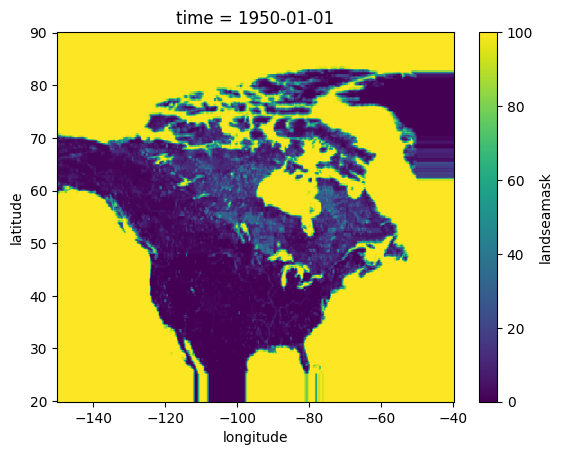

In [37]:
result.plot()

In [83]:
from utils.config import TrackerConfig
config = TrackerConfig()
csv_folder = config.paths.csv_folder
cao_cluster_table = config.files.cao_cluster_table
clusters = pd.read_csv(f"{csv_folder}/{cao_cluster_table}")

In [187]:
counts = clusters.groupby('time')['label'].count().reset_index()
counts.sort_values('label')

,time,label
21,1940-01-27,1
22,1940-01-28,1
23,1940-01-29,1
24,1940-01-31,1
25,1940-02-03,1
...,...,...
1820,1968-01-13,4
446,1948-02-10,4
2133,1972-02-20,5
353,1946-12-30,5


In [9]:
cao = xr.open_mfdataset(r"results\nc\labeled_nc\*.nc")
cao

<xarray.Dataset> Size: 36GB
Dimensions:                    (time: 12554, latitude: 201, longitude: 441)
Coordinates:
  * latitude                   (latitude) float32 804B 70.0 69.75 ... 20.25 20.0
  * longitude                  (longitude) float32 2kB -150.0 -149.8 ... -40.0
  * time                       (time) datetime64[ns] 100kB 1940-01-01 ... 202...
Data variables:
    daily_t2_max               (time, latitude, longitude) float32 4GB dask.array<chunksize=(152, 201, 441), meta=np.ndarray>
    daily_t2_min               (time, latitude, longitude) float32 4GB dask.array<chunksize=(152, 201, 441), meta=np.ndarray>
    anomaly                    (time, latitude, longitude) float32 4GB dask.array<chunksize=(152, 201, 441), meta=np.ndarray>
    scaled_anomaly             (time, latitude, longitude) float32 4GB dask.array<chunksize=(152, 201, 441), meta=np.ndarray>
    areas                      (time, latitude, longitude) float64 9GB dask.array<chunksize=(152, 201, 441), meta=np.ndarray>
    labeled_clusters_filtered  (time, latitude, longitude) int64 9GB dask.array<chunksize=(152, 201, 441), meta=np.ndarray>
    has_clusters               (time) bool 13kB dask.array<chunksize=(152,), meta=np.ndarray>

In [10]:
t1='1996-12-30'
t2='1947-02-06'
cao_chunk = cao.sel(time=t1)
daily_labels = cao_chunk['labeled_clusters_filtered']
unique_labels = np.unique(daily_labels.values)
unique_labels = unique_labels[unique_labels > 0] 
unique_labels

array([6])

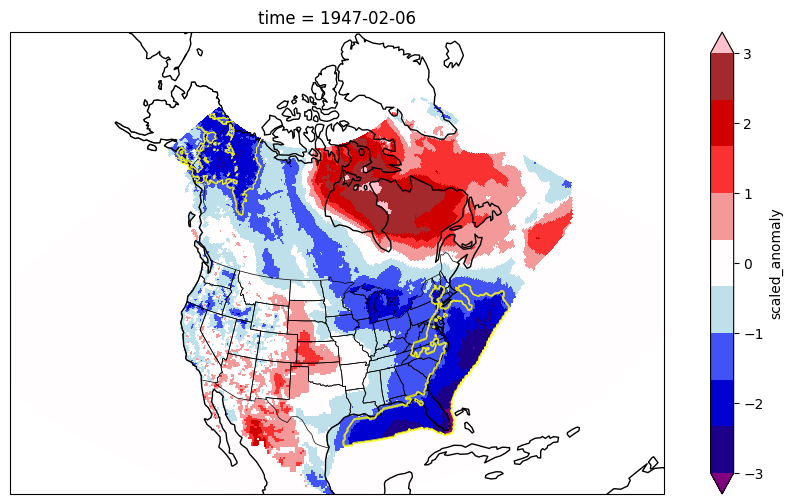

In [218]:
plt.figure(figsize=(12, 6))
axes = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-100))
plot_utils.da_plot_zero_centered(cao_chunk['scaled_anomaly'])
for l in unique_labels:
    cao_chunk['labeled_clusters_filtered'].where(cao_chunk['labeled_clusters_filtered']==l,0).plot.contour(transform=ccrs.PlateCarree(),colors='yellow',linewidths=0.3)
axes.coastlines()
axes.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
axes.set_extent((-140, -50, 20, 90),ccrs.PlateCarree())

In [216]:
regions_stack = np.stack([
    (cao_chunk['labeled_clusters_filtered'] == label)
    for label in unique_labels
], axis=0)

# Compute 2D distance transform for each region separately
distance_stack = np.stack([
    ndimage.distance_transform_edt(~regions_stack[i])  # 2D transform for each slice
    for i in range(len(unique_labels))
], axis=0)

# Calculate all pairwise minimum distances
min_distances = {}
pixel_res_km=111
for i, label1 in enumerate(unique_labels):
    for j, label2 in enumerate(unique_labels[i+1:], i+1):
        print(i,j)
        min_pixel_dist = distance_stack[i][regions_stack[j]].min()
        min_km_dist = min_pixel_dist * pixel_res_km
        min_distances[(label1, label2)] = min_km_dist
min_distances

0 1


{(np.int64(1), np.int64(34)): np.float64(744.6106365074301)}

In [189]:
label1 = 16#unique_labels[0]
label2 = 23#unique_labels[1]

region1 = cao.sel(time=t1)['labeled_clusters_filtered'] == label1 
region2 = cao.sel(time=t1)['labeled_clusters_filtered'] == label2

distances = ndimage.distance_transform_edt(~region1)
min_pixel_distance = distances[region2].min()
grid_resolution_km = 111  # adjust based on your actual grid
min_pixel_distance * grid_resolution_km

ValueError: zero-size array to reduction operation minimum which has no identity

0 1
0 2
0 3
0 4
1 2
1 3
1 4
2 3
2 4
3 4


{(np.int64(13), np.int64(17)): np.float64(5994.0),
 (np.int64(13), np.int64(47)): np.float64(10079.020041650874),
 (np.int64(13), np.int64(85)): np.float64(2997.0),
 (np.int64(13), np.int64(98)): np.float64(6010.421948582312),
 (np.int64(17), np.int64(47)): np.float64(3264.6079397073086),
 (np.int64(17), np.int64(85)): np.float64(8658.71150922584),
 (np.int64(17), np.int64(98)): np.float64(11069.432912304046),
 (np.int64(47), np.int64(85)): np.float64(8644.470197762266),
 (np.int64(47), np.int64(98)): np.float64(8030.4491779725495),
 (np.int64(85), np.int64(98)): np.float64(222.0)}

In [193]:
clusters = clusters.sort_values('area',ascending=False)
clusters[clusters.time==t1]

,label,area,time,cm_lat,cm_lon,mean,stdev,median,min_value,min_lat,min_lon
437,98,1.828694e+06,1947-01-01,159,178,-2.270447,0.539354,-2.195653,-4.275381,156,170
435,47,1.649584e+06,1947-01-01,88,348,-1.774698,0.218887,-1.729270,-2.501318,91,395
433,13,5.666400e+05,1947-01-01,47,146,-1.664948,0.117169,-1.649341,-2.082310,62,146
434,17,5.436802e+05,1947-01-01,38,256,-1.596180,0.058471,-1.584315,-1.774259,35,235
436,85,5.026208e+05,1947-01-01,115,160,-1.882473,0.252596,-1.858370,-2.874422,113,150


In [194]:
clusters[clusters.time==t2]

,label,area,time,cm_lat,cm_lon,mean,stdev,median,min_value,min_lat,min_lon
440,26,2.548722e+06,1947-01-02,91,148,-1.944428,0.313300,-1.894660,-3.376533,90,131
439,20,2.139368e+06,1947-01-02,87,403,-1.780282,0.225275,-1.715844,-2.478223,93,389
438,1,1.586891e+06,1947-01-02,30,273,-1.704759,0.127687,-1.694376,-2.218018,5,320
441,81,1.497920e+06,1947-01-02,159,176,-2.138062,0.465552,-2.035121,-3.954391,155,167


In [195]:
label1 = 23#unique_labels[0]
label2 = 28#unique_labels[1]

region1 = cao.sel(time=t1)['labeled_clusters_filtered'] == label1 
region2 = cao.sel(time=t2)['labeled_clusters_filtered'] == label2

distances = ndimage.distance_transform_edt(~region2)
min_pixel_distance = distances[region1].min()
grid_resolution_km = 111  # adjust based on your actual grid
min_pixel_distance * grid_resolution_km

ValueError: zero-size array to reduction operation minimum which has no identity

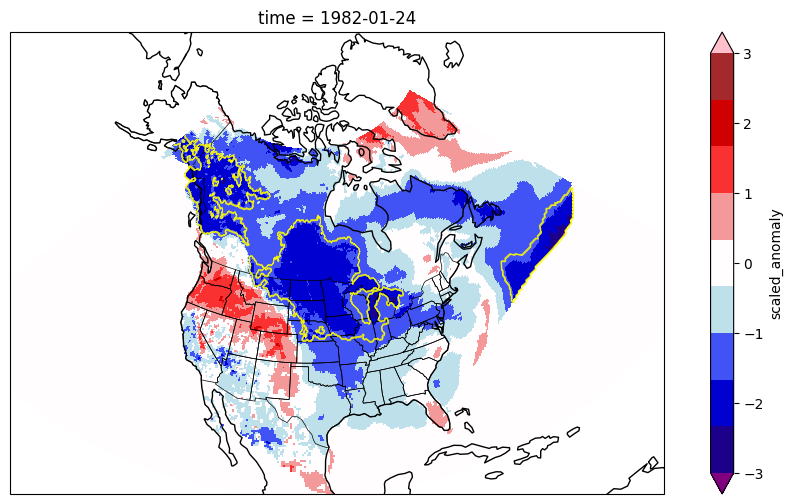